<a href="https://colab.research.google.com/github/Agresj/robot_vision_cnn/blob/main/robot_vision_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

importing

In [43]:
# Cell 1: Import Necessary Libraries

import torch
import time
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import random
import matplotlib.pyplot as plt


In [44]:
# Cell 2: Check for GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [45]:
# Cell 3: Set Random Seed

def set_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)


Define Data Transformations

In [46]:
# Cell 4: Define Enhanced Transformations for Training and Testing

# CIFAR-10 mean and std for normalization
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

# Enhanced data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),                    # 50% chance to flip horizontally
    transforms.RandomCrop(32, padding=4),                      # Randomly crop the image with padding
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)), # Random affine transformations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, 
                           saturation=0.2, hue=0.1),           # Randomly change brightness, contrast, saturation, and hue
    transforms.ToTensor(),                                     # Convert PIL Image to Tensor
    transforms.Normalize(mean, std),                           # Normalize with mean and std
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.33), 
                             ratio=(0.3, 3.3), value='random'),# Randomly erase a portion of the image
])

# Only normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),                                     # Convert PIL Image to Tensor
    transforms.Normalize(mean, std),                           # Normalize with mean and std
])


CIFAR-10 dataset

In [47]:
# Cell 5: Download and Load Training Data with Enhanced Transformations and Validation Split

from torch.utils.data import random_split

# Define the CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

# Define the ratio for training and validation splits
train_ratio = 0.9
val_ratio = 0.1

# Calculate the number of samples for each split
total_train = len(trainset)
train_size = int(train_ratio * total_train)
val_size = total_train - train_size

# Split the dataset into training and validation subsets
train_subset, val_subset = random_split(trainset, [train_size, val_size])

# Create DataLoaders for training and validation
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=128,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(val_subset, batch_size=128,
                                        shuffle=False, num_workers=2)

print(f"Training data loaded with {train_size} samples.")
print(f"Validation data loaded with {val_size} samples.")


Files already downloaded and verified
Training data loaded with 45000 samples.
Validation data loaded with 5000 samples.


In [48]:
# Cell 6: Download and Load Test Data

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

print("Test data loaded with", len(testset), "samples.")


Files already downloaded and verified
Test data loaded with 10000 samples.


In [49]:
# Cell 7: Define CIFAR-10 Classes

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Visualize some training images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


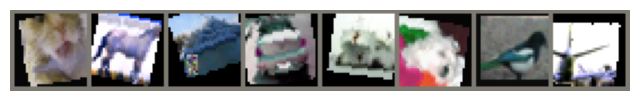

GroundTruth:  cat horse ship car ship dog bird plane


In [50]:
# Cell 8: Visualize Some Training Images

def imshow(img):
    # Unnormalize
    img = img * torch.tensor(std).view(3,1,1) + torch.tensor(mean).view(3,1,1)
    npimg = img.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))
# Print labels
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(8)))


CNN Architecture

In [51]:
# Cell 9: Define a Simpler CNN Architecture with Proper Initialization

import torch.nn as nn

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        # Activation function
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.1)
        # Dropout
        self.dropout = nn.Dropout(0.5)
        
        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Conv Layer 1
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.bn1(x)
        x = self.pool(x)
        # Conv Layer 2
        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.bn2(x)
        x = self.pool(x)
        # Conv Layer 3
        x = self.conv3(x)
        x = self.leaky_relu(x)
        x = self.bn3(x)
        x = self.pool(x)
        # Flatten
        x = x.view(-1, 256 * 4 * 4)
        # Fully connected layer 1
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        # Fully connected layer 2
        x = self.fc2(x)
        return x

# Instantiate the network
enhanced_net = SimpleNet()
enhanced_net.to(device)
print(enhanced_net)


SimpleNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.5, inplace=False)
)


Loss function and Optimizer

In [52]:
# Cell 10: Define Loss Function, Optimizer, and Scheduler

import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

criterion = nn.CrossEntropyLoss()  # No label smoothing as per specifications

# Optimizer: Stochastic Gradient Descent (SGD) with Momentum
optimizer = optim.SGD(enhanced_net.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler: Cosine Annealing
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

print("Loss function, SGD optimizer with reduced LR, and CosineAnnealingLR scheduler defined.")


Loss function, SGD optimizer with reduced LR, and CosineAnnealingLR scheduler defined.


Training configuration and Loop

In [53]:
# Cell 11: Set Training Parameters

num_epochs = 50  # As per specifications

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


In [54]:
# Cell 12: Implement the Training Loop with Gradient Clipping

import copy
import time

start_time = time.time()

best_val_acc = 0.0
best_model_wts = copy.deepcopy(enhanced_net.state_dict())
patience = 10  # Early stopping patience
trigger_times = 0

for epoch in range(num_epochs):
    enhanced_net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = enhanced_net(inputs)
        loss = criterion(outputs, labels)
        
        # Check for NaN in outputs or loss
        if torch.isnan(loss):
            print(f"NaN detected in loss at epoch {epoch+1}, batch {i+1}. Exiting training.")
            exit()
        if torch.isnan(outputs).any():
            print(f"NaN detected in outputs at epoch {epoch+1}, batch {i+1}. Exiting training.")
            exit()

        # Backward pass and optimize
        loss.backward()
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(enhanced_net.parameters(), max_norm=5.0)
        
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = 100. * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation phase
    enhanced_net.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = enhanced_net(images)
            loss = criterion(outputs, labels)
            
            # Check for NaN in validation outputs or loss
            if torch.isnan(loss):
                print(f"NaN detected in validation loss at epoch {epoch+1}. Exiting training.")
                exit()
            if torch.isnan(outputs).any():
                print(f"NaN detected in validation outputs at epoch {epoch+1}. Exiting training.")
                exit()

            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    epoch_val_loss = val_loss / len(valloader.dataset)
    epoch_val_acc = 100. * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    # Step the scheduler
    scheduler.step()

    # Logging
    print(f'Epoch [{epoch +1}/{num_epochs}] '
          f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}% '
          f'Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.2f}% '
          f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

    # Checkpointing
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        best_model_wts = copy.deepcopy(enhanced_net.state_dict())
        torch.save(best_model_wts, 'best_enhanced_cifar_net.pth')
        print(f'--> Best model saved with Validation Acc: {best_val_acc:.2f}%')
        trigger_times = 0
    else:
        trigger_times += 1

    # Early Stopping Check
    if trigger_times >= patience:
        print("Early stopping triggered!")
        break

end_time = time.time()
elapsed_time = (end_time - start_time) / 60
print(f"Training complete in {elapsed_time:.2f} minutes")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")


Epoch [1/50] Train Loss: 7.6666 | Train Acc: 24.27% Val Loss: 1.8075 | Val Acc: 35.24% LR: 0.049951
--> Best model saved with Validation Acc: 35.24%
Epoch [2/50] Train Loss: 1.7974 | Train Acc: 35.62% Val Loss: 1.5993 | Val Acc: 43.08% LR: 0.049803
--> Best model saved with Validation Acc: 43.08%
Epoch [3/50] Train Loss: 1.6276 | Train Acc: 41.50% Val Loss: 1.5153 | Val Acc: 45.24% LR: 0.049557
--> Best model saved with Validation Acc: 45.24%
Epoch [4/50] Train Loss: 1.5108 | Train Acc: 46.02% Val Loss: 1.4283 | Val Acc: 48.66% LR: 0.049215
--> Best model saved with Validation Acc: 48.66%
Epoch [5/50] Train Loss: 1.4113 | Train Acc: 49.63% Val Loss: 1.3928 | Val Acc: 50.82% LR: 0.048777
--> Best model saved with Validation Acc: 50.82%
Epoch [6/50] Train Loss: 1.3435 | Train Acc: 51.92% Val Loss: 1.2708 | Val Acc: 55.04% LR: 0.048245
--> Best model saved with Validation Acc: 55.04%
Epoch [7/50] Train Loss: 1.2875 | Train Acc: 54.16% Val Loss: 1.2382 | Val Acc: 55.98% LR: 0.047621
--> Be

Test Network on Test Data

In [55]:
# Cell 13: Final Evaluation on Test Data

# Load the best model weights
enhanced_net.load_state_dict(torch.load('best_enhanced_cifar_net.pth'))
enhanced_net.eval()

correct = 0
total = 0
test_loss = 0.0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = enhanced_net(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

final_test_loss = test_loss / len(testloader.dataset)
final_test_acc = 100. * correct / total

print(f'Final Test Loss: {final_test_loss:.4f} | Final Test Accuracy: {final_test_acc:.2f}%')


Final Test Loss: 0.4768 | Final Test Accuracy: 83.39%


Performance Metrics

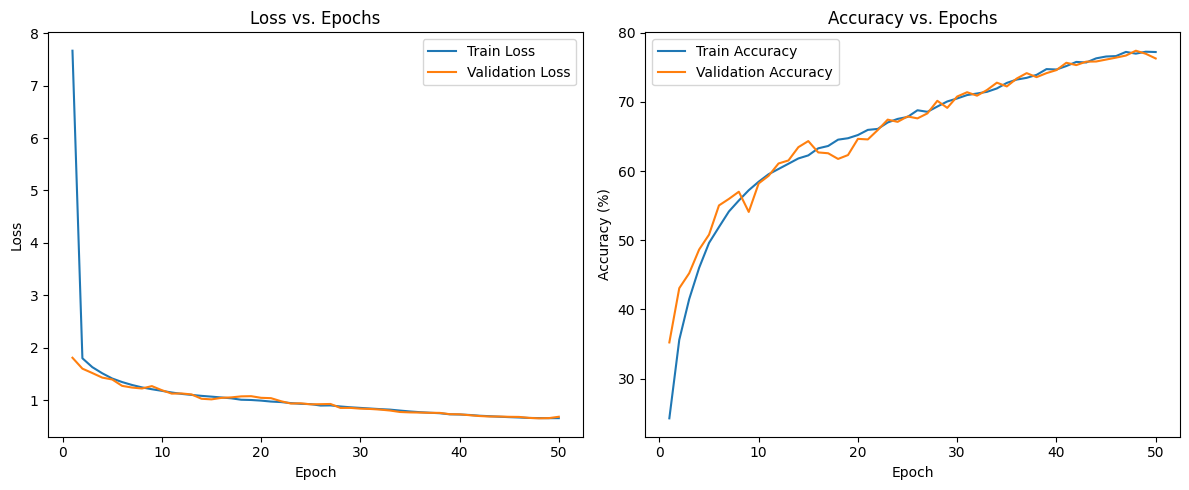

In [56]:
# Cell 14: Plot Loss and Accuracy Curves

# Plotting Loss and Accuracy curves
epochs = range(1, len(train_losses) +1)

plt.figure(figsize=(12,5))

# Plot Loss
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


Visualize Sample Test Predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


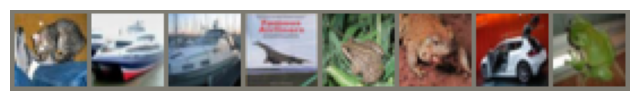

GroundTruth:  cat ship ship plane frog frog car frog
Predicted:  dog ship ship ship frog frog car frog


In [57]:
# Cell 15: Display Some Test Images with Predictions

# Get some random test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Move images and labels to the same device as the model
images, labels = images.to(device), labels.to(device)

# Get predictions
outputs = enhanced_net(images)
_, predicted = outputs.max(1)

# Move images and labels back to CPU for plotting
images = images.cpu()
predicted = predicted.cpu()
labels = labels.cpu()

# Function to show images
def imshow(img):
    # Unnormalize
    img = img * torch.tensor(std).view(3,1,1) + torch.tensor(mean).view(3,1,1)
    npimg = img.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Show images
imshow(torchvision.utils.make_grid(images[:8]))
# Print ground truth and predictions
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(8)))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]}' for j in range(8)))


Saving the model

In [58]:
# Cell 16: Save the Enhanced Trained Model

# Save the enhanced trained model
PATH = './85_percent_cifar_net.pth'
torch.save(enhanced_net.state_dict(), PATH)
print(f"Enhanced model saved to {PATH}")


Enhanced model saved to ./85_percent_cifar_net.pth
